# Import

In [1]:
import pandas as pd
import os
from os.path import join
from datetime import datetime, timezone, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import logging
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from yforseer.networks import StockNet
from yforseer.datasets import StockDataset
from yforseer.trainers import StockNetTrainer
import mlflow
from tqdm import tqdm

from yforseer.scraping import RawDF_Schema

# Dataset and loader

In [2]:

# Load dataset
load_array_pth = 'data/yahoo/artifacts/data_array.npz'
data = torch.from_numpy(np.load(load_array_pth)['data']).to(torch.float32)
num_days = data.shape[1]
test_size = int(0.1 * num_days)
train_size = num_days - test_size
train_data = data[:, :train_size]
test_data = data[:, train_size:]
train_dataset = StockDataset(data = train_data, memory=60, lookahead=30, mode='last')
test_dataset = StockDataset(data = test_data, memory=60, lookahead=30, mode='last')
print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))


train_dataset: 5289
test_dataset: 508


Data

In [3]:
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_x_test = []
all_y_test = []
for X_test, y_test in test_dataloader:
    all_x_test.append(X_test.numpy())
    all_y_test.append(y_test.numpy().squeeze())

all_x_test = np.concatenate(all_x_test, axis=0)
all_y_test = np.concatenate(all_y_test, axis=0)

print(all_x_test.shape)
print(all_y_test.shape)


(508, 71, 60)
(508, 71)


In [4]:
from yforseer.evaluate import compute_return_rate, weighted_return, evaluate_stock_trend_prediction
xlast = all_x_test[:, :, -1]
ytest = all_y_test
ypred = all_x_test[:, :, -1]


evaluate_stock_trend_prediction(xlast, ypred, ytest)

change_pred = (ypred - xlast) / xlast
change_test = (ytest - xlast) / xlast


# # Buy return rate

buy_returns = compute_return_rate(change_pred, change_test, mode='buy')
perfect_buy_returns = compute_return_rate(change_test, change_test, mode='buy')




In [17]:
buy_returns.shape

(508, 3)

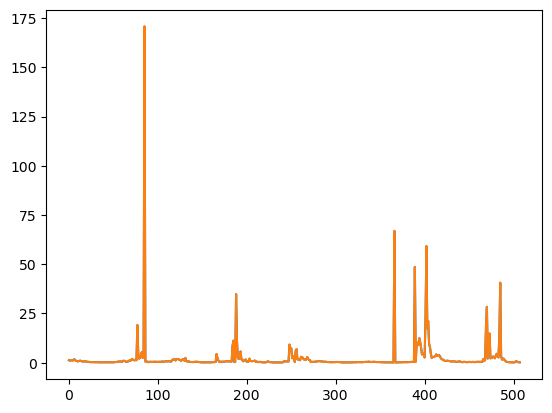

In [18]:
allreturns = perfect_buy_returns[:, 1]
allreturns2 = perfect_buy_returns2[:, 1]
plt.plot(allreturns)
plt.plot(allreturns2)

In [19]:
for i in range(3):
    all = np.all(buy_returns[:, i] == buy_returns2[:, i])
    allperfect = np.all(perfect_buy_returns[:, i] == perfect_buy_returns2[:, i])
    print(all, allperfect)


True True
True True
True True


In [29]:
change_test_copied = change_test.copy()


# Buy or Sell mode
mask = change_test <= 0
trade_sign = 1 

# Sort    
change_test_copied[mask] = 0
perfect_sorted_inds = np.argsort(trade_sign*change_test_copied, axis=-1)
M = perfect_sorted_inds.shape[-1]

trade_returns = []
perfect_trade_returns = []
i = M
selected_perfect_sorted_tops_inds = perfect_sorted_inds[:, -i:]
sorted_perfect_change_test = np.take_along_axis(change_test_copied, selected_perfect_sorted_tops_inds, axis=1)

# Compute return with perfect prediction
perfect_trade_return = weighted_return(sorted_perfect_change_test, trade_sign*sorted_perfect_change_test, batch=True)

print(perfect_trade_return)

[8.71830583e-01 6.73267007e-01 7.64223814e-01 7.82622933e-01
 7.68188655e-01 7.75487304e-01 1.23985815e+00 8.50558877e-01
 5.99028587e-01 5.08179724e-01 3.91886830e-01 4.77472514e-01
 6.37842059e-01 6.26283586e-01 4.96546268e-01 3.42527688e-01
 3.91509861e-01 3.18051666e-01 5.44604897e-01 3.88175845e-01
 3.02460521e-01 2.86984146e-01 2.09992230e-01 1.82098627e-01
 1.44974783e-01 1.68917120e-01 1.40459716e-01 1.25529408e-01
 1.29095793e-01 1.31592244e-01 1.14016473e-01 1.25483364e-01
 1.30807385e-01 1.07293516e-01 8.80019441e-02 9.50987786e-02
 9.78420228e-02 9.73809659e-02 9.42154527e-02 8.93580317e-02
 8.72087032e-02 9.40063000e-02 9.49084088e-02 7.99383223e-02
 8.51881653e-02 8.33862275e-02 8.98237452e-02 1.13684498e-01
 1.20986879e-01 1.07186943e-01 1.03374973e-01 1.17852032e-01
 1.97147578e-01 2.36568242e-01 2.17642039e-01 3.28943133e-01
 3.86310756e-01 3.43572080e-01 4.33356345e-01 3.50633919e-01
 2.66214430e-01 6.60576344e-01 6.33427382e-01 5.81717610e-01
 3.12369823e-01 2.861435

# Bull/Bear

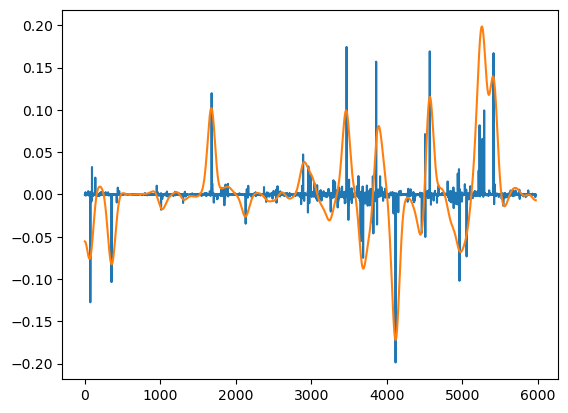

In [31]:
from scipy.ndimage import gaussian_filter1d

xdiff = np.diff(data, axis=1)

xdiff = np.append(xdiff, np.zeros((xdiff.shape[0], 1)), axis=1)

frac_change = xdiff/ data

trend = np.mean(frac_change, axis=0)

# 


smooth_trend = gaussian_filter1d(trend, 50)

plt.plot(trend/np.abs(trend).max() * np.abs(smooth_trend).max())

plt.plot(smooth_trend)